# Image similarity model


In [162]:
from tensorflow.keras.layers import Flatten, Dense, Input,concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import tensorflow as tf
import cv2
from scipy.spatial import distance
import os
import numpy as np

### Import VGG16 model from Tensorflow

In [35]:
vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=True, pooling='max', input_shape=(224, 224, 3))

In [8]:
basemodel = Model(inputs=vgg16.input, outputs=vgg16.get_layer('fc2').output)

In [194]:
#basemodel.summary()

### Vectorizer for images

In [38]:
def get_feature_vector(img):
 img1 = cv2.resize(img, (224, 224))
 feature_vector = basemodel.predict(img1.reshape(1, 224, 224, 3))
 return feature_vector

### Calculate similarity function

In [21]:
def calculate_similarity(vector1, vector2):
 return distance.cosine(vector1, vector2)

### Create vectors for all images in local folder

In [157]:
directory = '/home/beres/code/tklein98/crate_scanner/notebooks/images/'
vectors = []

for filename in os.listdir(directory):
    img = cv2.imread(f'images/{filename}')
    img1 = get_feature_vector(img)
    vectors.append([filename, img1.copy()])

### Import test image and find similar image

In [190]:
img1 = cv2.imread("dummy2.jpg")

f1 = get_feature_vector(img1)
comparison = []

for vector in vectors:
    for i in vector[1]:
        comparison.append(calculate_similarity(f1, i))
        

### Retrieve details for closest match

Abbey Road The Beatles.jpg


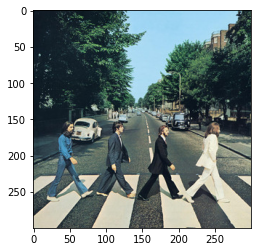

In [191]:
index = comparison.index(min(comparison))
album = vectors[index][0]
print(album)
album = cv2.imread(f'images/{album}')[:,:,::-1]
plt.imshow(album)


### The vector file can be saved and retrieved as follows;

In [179]:
# The vectors array has been saved to the notebooks folder in the project repo 
array = np.array(vectors)
np.save('array', array)

In [185]:
## Load saved file using the following code; x_loaded = np.load(path/'x.npy')
x_loaded = np.load('array.npy', allow_pickle = True)